<a href="https://colab.research.google.com/github/LucaswasTaken/NES-DataScience/blob/main/Aula8/Aula_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aumento de dados

## Objetivos

* Aumentar o conjunto de dados da ASL
* Use os dados aumentados para treinar um modelo melhorado
* Salvar o modelo bem treinado em disco para uso na implantação

## Preparando os dados

In [1]:
from google.colab import files
uploaded = files.upload()


Saving sign_mnist_train.csv to sign_mnist_train.csv
Saving sign_mnist_valid.csv to sign_mnist_valid.csv


In [3]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("./sign_mnist_train.csv")
valid_df = pd.read_csv("./sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Criação do modelo

Também precisaremos criar nosso modelo novamente. Para isso, execute a seguinte célula. Você vai notar que esta é a mesma arquitetura de modelo da última seção:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Aumentação de dados

Antes de compilar o modelo, é hora de configurar nossa ampliação de dados.

Keras vem com uma classe de aumento de imagem chamada `ImageDataGenerator`. Recomendamos verificar a [documentação aqui](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Ele aceita uma série de opções para o aumento de seus dados. Mais tarde no curso, faremos com que você selecione uma estratégia de aumento adequada. Por enquanto, dê uma olhada nas opções que selecionamos abaixo, e depois execute a célula para criar uma instância da classe:

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)

Tire um momento para pensar por que queremos virar as imagens horizontalmente, mas não verticalmente. Quando você tiver uma idéia, revele o texto abaixo.

## Tamanho do lote
Outro benefício do 'ImageDataGenerator' é que ele [lotes](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) nossos dados para que nosso modelo possa ser treinado em uma amostra aleatória.

Se o modelo for [verdadeiramente aleatório](http://sites.utexas.edu/sos/random/), o que significa que os dados são embaralhados corretamente para que seja justo como um baralho de cartas, então nossa amostra pode fazer um bom trabalho de representação de todos os nossos dados, mesmo que seja uma fração minúscula da população. Para cada etapa do treinamento, o modelo será tratado um novo lote.

Na prática, um lote de 32 e 64 faz bem. Execute a célula abaixo para ver com que tipo de lotes estaremos treinando nosso modelo. Nosso randomizador é bastante randomizado? Todas as imagens são letras ASL reconhecíveis?

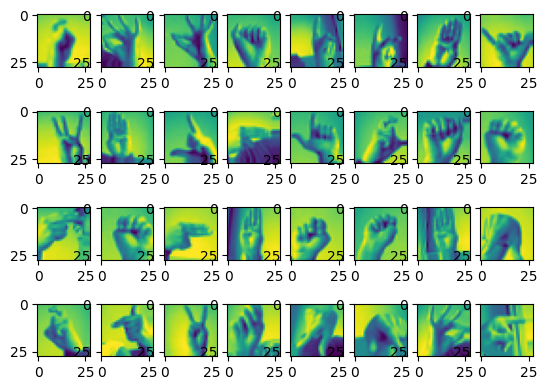

In [7]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = next(img_iter)

fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Adjusting the data to the Generator

Em seguida, o gerador deve estar em conformidade com o conjunto de dados de treinamento.

In [8]:
datagen.fit(x_train)

## Compilando o modelo

Com a instância geradora de dados criada e adequada aos dados de treinamento, o modelo pode agora ser compilado da mesma forma que nossos exemplos anteriores:

In [9]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Treinamento com aumento

Ao utilizar um gerador de dados de imagem com Keras, um modelo treina um pouco diferente: em vez de apenas passar os conjuntos de dados `x_train` e `y_train` para o modelo, nós passamos o gerador, chamando o método [fluxo](https://keras.io/api/preprocessing/image/) do gerador. Isto faz com que as imagens sejam aumentadas ao vivo e em memória antes de serem passadas para o modelo para treinamento.

Os geradores podem fornecer uma quantidade indefinida de dados, e quando os usamos para treinar nossos dados, precisamos definir explicitamente quanto tempo queremos que cada época funcione, caso contrário, a época continuará indefinidamente, com o gerador criando um número indefinido de imagens aumentadas para fornecer o modelo.

Definimos explicitamente o tempo que queremos que cada época funcione utilizando o argumento 'passos_por_epoch' nomeado. Porque `steps * batch_size = number_of_images_training in an epoch` uma prática comum, que utilizaremos aqui, é definir o número de etapas igual ao tamanho do conjunto de dados não-agmentado dividido pelo tamanho_do_lote (que tem um valor padrão de 32).

Execute a seguinte célula para ver os resultados. O treinamento levará mais tempo do que antes, o que faz sentido já que agora estamos treinando mais dados do que anteriormente:

In [11]:
import math

model.fit(
    img_iter,
    epochs=10,
    steps_per_epoch=math.ceil(len(x_train) / batch_size),  # Arredonda pra cima
    validation_data=(x_valid, y_valid)
)


Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 124s 142ms/step - accuracy: 0.4603 - loss: 1.7752 - val_accuracy: 0.8412 - val_loss: 0.4779
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 119s 139ms/step - accuracy: 0.8747 - loss: 0.3709 - val_accuracy: 0.7734 - val_loss: 0.7071
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 137s 134ms/step - accuracy: 0.9246 - loss: 0.2220 - val_accuracy: 0.9264 - val_loss: 0.2076
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 115s 134ms/step - accuracy: 0.9450 - loss: 0.1721 - val_accuracy: 0.8798 - val_loss: 0.3743
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - accuracy: 0.9584 - loss: 0.1350 - val_accuracy: 0.9158 - val_loss: 0.2459
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 119s 139ms/step - accuracy: 0.9666 - loss: 0.1012 - val_accuracy: 0.9568 - val_loss: 0.1301
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 140s 137ms/step - accuracy: 0.9690 - loss: 0.0929 - val_accuracy: 0.9873 - val_loss: 0.0475
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 119s 139ms/step - accuracy: 0.9707 -

## Discussão dos resultados

Você notará que a precisão da validação é maior e mais consistente. Isto significa que nosso modelo não se ajusta mais da maneira que era; ele generaliza melhor, fazendo melhores previsões sobre novos dados.

## Salvando o modelo

Agora que temos um modelo bem treinado, vamos querer implantá-lo para fazer inferências sobre novas imagens.

É comum, uma vez que temos um modelo treinado com o qual estamos satisfeitos em salvá-lo em disco.

Salvar o modelo em Keras é bastante fácil, utilizando o método de salvamento. Há diferentes formatos nos quais podemos salvar, mas usaremos o padrão por enquanto. Se você quiser, fique à vontade para conferir [a documentação](https://www.tensorflow.org/guide/keras/save_and_serialize). No próximo caderno, carregaremos o modelo e o usaremos para ler novas imagens em linguagem de sinais:

In [13]:
model.save('asl_model.keras')

## Carregando o modelo
Agora que estamos em um novo notebook, vamos carregar o modelo salvo que treinamos. Nosso save do exercício anterior criou uma pasta chamada "asl_model". Podemos carregar o modelo selecionando a mesma pasta.

In [14]:
from tensorflow import keras

model = keras.models.load_model('asl_model.keras')

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,800 (2.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

 Optimizer params: 263,751 (1.01 MB)

## Preparando uma imagem para o modelo

Agora é hora de usar o modelo para fazer previsões sobre novas imagens que ele nunca viu antes. Isto também é chamado de inferência. Nós lhe demos um conjunto de imagens na pasta data/asl_images. Tente abri-la usando a navegação à esquerda e explore as imagens.

Você notará que as imagens que temos são de muito maior resolução do que as imagens em nosso conjunto de dados. Elas também estão em cores. Lembre-se de que nossas imagens no conjunto de dados eram de 28x28 pixels e escala de cinza. É importante ter em mente que sempre que você fizer previsões com um modelo, a entrada deve combinar com a forma dos dados sobre os quais o modelo foi treinado. Para este modelo, o conjunto de dados de treinamento era da forma: (27455, 28, 28, 1). Isto correspondeu a 27455 imagens de 28 por 28 pixels cada uma com um canal de cor (escala de cinza).

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

In [17]:
show_image('sua imagem')

FileNotFoundError: [Errno 2] No such file or directory: 'data/asl_images/b.png'

### Escalando as imagens

As imagens em nosso conjunto de dados eram de 28x28 pixels e em escala de cinza. Precisamos ter certeza de passar o mesmo tamanho e imagens em escala de cinza em nosso método de previsão. Há algumas maneiras de editar imagens com Python, mas Keras tem um utilitário incorporado que funciona bem.

In [18]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

In [19]:
image = load_and_scale_image('data/asl_images/b.png')
plt.imshow(image, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'data/asl_images/b.png'

### Preparando a Imagem para a Predição

Agora que temos uma imagem em escala de cinza de 28x28 pixels, estamos perto de estar prontos para passá-la para o nosso modelo de previsão. Primeiro precisamos remodelar nossa imagem para adequá-la à forma do conjunto de dados em que o modelo foi treinado. Antes de podermos remodelar, precisamos converter nossa imagem em um formato mais rudimentar. Faremos isso com um utilitário de keras chamado image_to_array.

In [20]:
image = image_utils.img_to_array(image)

Agora podemos reformular nossa imagem para prepará-la para a previsão.

In [21]:
# This reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image.reshape(1,28,28,1)

Finalmente, devemos lembrar de normalizar nossos dados (fazendo todos os valores entre 0-1), como fizemos com nosso conjunto de dados de treinamento:

In [22]:
image = image / 255

## Fazendo Previsões

Pronto, agora estamos prontos para prever! Isto é feito passando nossa imagem pré-processada para o método de previsão do modelo.

In [ ]:
prediction = model.predict(image)
print(prediction)

### Entendendo a Previsão

As previsões estão no formato de uma matriz de 24 comprimentos. Embora pareça um pouco diferente, este é o mesmo formato de nossas matrizes categóricas "binarizadas" de y_train e y_test. Cada elemento da matriz é uma probabilidade entre 0 e 1, representando a confiança para cada categoria. Vamos torná-la um pouco mais legível. Podemos começar encontrando qual elemento da matriz representa a maior probabilidade. Isto pode ser feito facilmente com a biblioteca numérica e a função [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [ ]:
import numpy as np
np.argmax(prediction)

Cada elemento da matriz de previsão representa uma possível letra no alfabeto da linguagem dos sinais. Lembre-se de que j e z não são opções porque envolvem mover a mão, e estamos lidando apenas com fotos estáticas. Vamos criar um mapeamento entre o índice da matriz de predições, e a letra correspondente.

In [ ]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

Agora podemos passar em nosso índice de previsão para encontrar a carta correspondente.

In [ ]:
alphabet[np.argmax(prediction)]

## Exercício: Colocar tudo junto

Vamos colocar tudo em uma função para que possamos fazer previsões apenas a partir do arquivo de imagem. Implementar na função abaixo, utilizando as funções e passos acima. Se você precisar de ajuda, você pode revelar a solução clicando nos três pontos abaixo.

In [ ]:
# SOLUTION
def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1)
    image = image/255
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = alphabet[np.argmax(prediction)]
    return predicted_letter

In [ ]:
predict_letter("Foto dasua mão")